## Notebook JetCar_Auto_Drive
### Let it drive on the streets alone 
> This notebook enables the car to drive autonomously with user control of the next turns
***

<br>
Import major libraries for this notebook

In [1]:
import os
import torch
import torchvision
import cv2
import ipywidgets
import traitlets
from IPython.display import display
from jetcam.utils import bgr8_to_jpeg
from utils import preprocess,load_color_map
import numpy as np
from torch2trt import torch2trt
import segmentation_models_pytorch as smp
device = torch.device('cuda')

<div class="alert alert-block alert-info">
<b>Note:</b> After creating a new streetmap with training, make sure to update the N_CLASSES, and SegmClass assignments in ``jetcar_definitions.py`` from StreetMaker output file JetCar_Classes.txt.
</div>

In [2]:
from jetcar_definitions import *

Read the color assignments from StreetMaker to colorcode the classes correctly

In [3]:
color_map = load_color_map("JetCar_ColorMap.csv")

Color map loaded!


Instantiate the NN model object 

In [4]:
model = smp.Unet(encoder_name="mobilenet_v2", classes=N_CLASSES, activation='argmax2d')

Load the model weights created by the training model

In [5]:
model.load_state_dict(torch.load('JetCar_Best_MobileNetV2_Model_Weights_Catalyst.pth'))
model = model.cuda().eval().half()
model = model.to(device)

Create the real-time camera image and mask widgets

In [6]:
WIDGET_SIZE=IMG_SIZE
camera_widget = ipywidgets.Image(width=WIDGET_SIZE, height=WIDGET_SIZE)
mask_widget = ipywidgets.Image(width=WIDGET_SIZE, height=WIDGET_SIZE)

Create text area widgets for displaying the detected objects in the lane center, the lane to the left and the lane to the right

In [7]:
lane_left_objects_text = ipywidgets.Textarea(value='', rows=14, layout={'width': '250px', 'height': '260px'})
lane_center_objects_text = ipywidgets.Textarea(value='', rows=14, layout={'width': '250px', 'height': '260px'})
lane_right_objects_text = ipywidgets.Textarea(value='', rows=14, layout={'width': '250px', 'height': '260px'})

Create informational text output widgets and the stop button

In [8]:
process_status_text_widget = ipywidgets.Text(value='', layout={'width': '1000px'})
timing_text_widget = ipywidgets.Text(value='', layout={'width': '1000px'}, visible=False)
exception_text_widget = ipywidgets.Text(value='', layout={'width': '1000px'})
stop_button = ipywidgets.Button(description="Stop", layout={'width': '1000px'})

Import JetCar hardware class and instantiate car object

In [9]:
from jetcar_car import JetCar
car = JetCar()

Create a number of checkboxes to control outputs and some car features 

In [10]:
auto_steering_widget = ipywidgets.Checkbox(value=True, description='Auto Steering',layout={'width': '225px'} )
auto_throttle_widget = ipywidgets.Checkbox(value=True, description='Auto Throttle', layout={'width': '225px'} )
mask_update_widget   = ipywidgets.Checkbox(value=True, description='Mask Update', layout={'width': '225px'} )
object_update_widget = ipywidgets.Checkbox(value=True, description='Object Lists Update', layout={'width': '225px'} )
head_light_low_widget = ipywidgets.Checkbox(value=False, description='Head Light Low Beam', layout={'width': '225px'} )
head_light_high_widget = ipywidgets.Checkbox(value=False, description='Head Light High Beam', layout={'width': '225px'} )

Create steering slider for visualization or manual control if enabled.<br>
The throttle slider defines the maximum throttle in autonomous mode or gives full throttle control in manual mode.<br>
The throttle progress shows the scaled autonomous throttle control when driving. 

In [11]:
steering_value_slider = ipywidgets.FloatSlider(min=-1.0, max=1.0, step=0.001, description='steering', layout={'width': '1000px'}, disabled=True)
throttle_value_slider = ipywidgets.FloatSlider(min=-1.0, max=1.0, step=0.001, value=car.throttle, description='throttle max',layout={'width': '1000px'})
throttle_value_progress = ipywidgets.FloatProgress(value=0,min=0.5,max=1,step=0.01,description='throttle',orientation='vertical',layout={'height': '100px'})

The following event handler allow switching between autonomous steering and throttling and manual.

In [12]:
def on_auto_steering_widget_change(change):
    steering_value_slider.disabled = change['new'] 
    if change['new'] == False:
        car.steering = steering_value_slider.value
auto_steering_widget.observe(on_auto_steering_widget_change, names='value')  

def on_auto_throttle_widget_change(change):
    if change['new'] == False:
        car.throttle = throttle_value_slider.value
auto_throttle_widget.observe(on_auto_throttle_widget_change, names='value')

def on_steering_value_slider_change(change):
    if auto_steering_widget.value == False:
        car.steering = change['new']
steering_value_slider.observe(on_steering_value_slider_change, names='value')

def on_throttle_value_slider_change(change):
    if auto_throttle_widget.value == False:
        car.throttle = change['new']
throttle_value_slider.observe(on_throttle_value_slider_change, names='value')

Create radiobutton style checkboxes and event handler to chose the directions for the next possible turn.

In [13]:
direction_left_widget = ipywidgets.Checkbox(value=False, description='Next Turn Left', layout={'width': '225px'})
direction_straight_widget = ipywidgets.Checkbox(value=True, description='Next Go Straight', layout={'width': '225px'})
direction_right_widget = ipywidgets.Checkbox(value=False, description='Next Turn Right', layout={'width': '225px'})
next_turn_direction = Direction.Straight

def on_direction_left_change(change):
    global next_turn_direction, direction_straight_widget, direction_right_widget
    if change['new'] == True:
        next_turn_direction = Direction.Left
        direction_straight_widget.value = False
        direction_right_widget.value = False
direction_left_widget.observe(on_direction_left_change, names='value')

def on_direction_straight_change(change):
    global next_turn_direction, direction_left_widget, direction_right_widget
    if change['new'] == True:
        next_turn_direction = Direction.Straight
        direction_left_widget.value = False
        direction_right_widget.value = False
direction_straight_widget.observe(on_direction_straight_change, names='value')

def on_direction_right_change(change):
    global next_turn_direction, direction_left_widget, direction_straight_widget
    if change['new'] == True:
        next_turn_direction = Direction.Right
        direction_straight_widget.value = False
        direction_left_widget.value = False
direction_right_widget.observe(on_direction_right_change, names='value')

In [14]:
def on_head_light_low_change(change):
    if change['new'] == True:
        car.head_light_low = 1
        car.tail_light = 1
    else:
        car.head_light_low = 0
        if head_light_high_widget.value == False:
            car.tail_light = 0
head_light_low_widget.observe(on_head_light_low_change, names='value')

def on_head_light_high_change(change):
    if change['new'] == True:
        car.head_light_high = 1
        car.tail_light = 1
    else:
        car.head_light_high = 0
        if head_light_low_widget.value == False:
            car.tail_light = 0
head_light_high_widget.observe(on_head_light_high_change, names='value')


Create indicators for internally detected fields while driving autonomously

In [15]:
intersection_widget = ipywidgets.Valid(value=True, description="intersection:",layout={'width': '200px'})
turn_left_allowed_widget = ipywidgets.Valid(value=False, description="turn left:",layout={'width': '200px'})
go_straight_allowed_widget = ipywidgets.Valid(value=False, description="go straight:",layout={'width': '200px'})
turn_right_allowed_widget = ipywidgets.Valid(value=False, description="turn right:",layout={'width': '200px'})
stop_detected_widget = ipywidgets.Valid(value=False, description="stop:",layout={'width': '200px'})

Create the layout of all widgets on the screen

In [16]:
display_widgets = ipywidgets.VBox([
    ipywidgets.HBox([camera_widget, mask_widget, lane_left_objects_text, lane_center_objects_text, lane_right_objects_text]), 
    ipywidgets.HBox([auto_steering_widget,auto_throttle_widget,mask_update_widget,object_update_widget]),
    ipywidgets.HBox([process_status_text_widget,head_light_high_widget]),
    ipywidgets.HBox([timing_text_widget,head_light_low_widget]),
    ipywidgets.HBox([
        ipywidgets.VBox([ipywidgets.HBox([intersection_widget,turn_left_allowed_widget,go_straight_allowed_widget,turn_right_allowed_widget,stop_detected_widget]),
                        steering_value_slider,
                        throttle_value_slider]),
        throttle_value_progress,
    ]),       
    exception_text_widget,
    ipywidgets.HBox([direction_left_widget, direction_straight_widget, direction_right_widget]),
    stop_button
])

Import the lane tracker and instantiate the object

In [17]:
from jetcar_tracker import *
tracker = LaneTracker()

Import and instantiate the timing object for analysis

In [18]:
from simple_timing import SimpleTiming
timing = SimpleTiming(6,10000)

Define a function for filling a textarea widget with detected objects.
> Since the object lists start from the car front, the objects closer to it will be<br>
listed at the bottom to better relate to the real-time image and mask display next to it.

In [19]:
def get_object_list_text(objects):
    s = ""
    for i in range(15-len(objects)):
        s += f'\n'
    for i in reversed(range(len(objects))):
        s += f'\n{objects[i]}'
    return s

Filll the three text area widgets with the objects from left lane, driving lane and right lane

In [20]:
def fill_object_list_widgets():
    lane_left_objects_text.value = get_object_list_text(tracker.lane_left.objects)
    lane_center_objects_text.value = get_object_list_text(tracker.lane_center.objects)
    lane_right_objects_text.value = get_object_list_text(tracker.lane_right.objects)                

The following function saves the current real-time image and the created mask from the model inference into files for later offline debugging.

In [21]:
def save_img_and_mask(recording_dir, img_count, image, mask):
    filename = 'Img_%03d.jpg' % (img_count)
    image_path = os.path.join(recording_dir, filename)
    cv2.imwrite(image_path, image)

    filename = 'Mask_%03d.npy' % (img_count)
    mask_path = os.path.join(recording_dir, filename)
    np.save(mask_path, mask)


Import and instantiate camera object with full field of view scaled down to mdel image size

In [22]:
from jetcam.csi_camera import CSICamera
camera = CSICamera(width=IMG_SIZE, height=IMG_SIZE, capture_width=3280, capture_height=2464, capture_fps=4)
img_count = 0

The following cell allows setting up debug and start conditions. <br>
It can be useful to test a certain scenery with turning on recording and direction preset left or right turn where the issue happens.

In [23]:
from utils import make_or_clear_directory

recording_dir = "DebugData/"
make_or_clear_directory(recording_dir)

SAVE_IMG_AND_MASK = False   # set to True for recording image and mask in real-time for offline debugging
throttle_value_slider.value = 0.25
direction_straight_widget.value = True
auto_steering_widget.value = True

log_file = open(os.path.join(recording_dir, "log_file.csv"), 'w')
log_file.write("cnt,nst,st,dir,stfcnt,stpcnt,thro,stctrl,len,ren\n")

def write_log_file_line():
    log_file.write("%d,%.3f,%.3f,%s,%d,%d,%.3f,%s,%s,%s\n" % \
            (img_count, tracker.new_steering_value, tracker.steering_value, Direction(tracker.direction), tracker.steering_fixed_count, tracker.stop_count, tracker.throttle_value, \
             tracker.steering_control, tracker.signal_left_enable, tracker.signal_right_enable))


Could not delete .ipynb_checkpoints !


Below is the camera event handler function to process each incoming frame.<br>
To avoid any lag and to keep the execution synchronized, the execution time is measured and <br>
checked against the frame time. It is better to skip a frame than falling more and more behind.<br>
The time measurements are buffered and can be displayed as a graph after real-time execution is stopped.<br>
>Each camera frame is passed through the model to create the segmentation mask.<br>
The mask is then then passed on to the tracker object for processing together with the next turn request.<br>
Results from the tracker object are then passed to the car object<br>
Everything else is for visualization and debugging

In [24]:
skip_threshold = 1/camera.capture_fps

def execute(change):
    global image,classes,mask,mask_img, throttle, img_count, tick_counter
    
    # get the new frame
    image = change['new']  
    
    # Check the timing, if last processing took too long, just exit
    if timing.time_delta[-1] > skip_threshold:
        timing.time_delta[-1] = 0
        return
    
    # Start timing for this cycle
    timing.measure_time(0,0)

    # Infer camera frame and get the 8bit class mask
    mask = model(preprocess(image)).detach().squeeze().cpu().numpy().astype(np.uint8)

    # If enabled, save image frame and mask 
    if SAVE_IMG_AND_MASK == True:
        save_img_and_mask(recording_dir, img_count, image, mask)

    # Measure and store the time for the mask creation
    timing.measure_time(1,0)

    # Except in the initial execution, now let the tracker object process the mask
    if img_count > 0:
        try:
            tracker.process(mask, next_turn_direction)
        except Exception as e:
            exception_text_widget.value = str(e)
       
    # Measure and store the time for the tracker processing
    timing.measure_time(2,1)
    
    # In autonomous steering mode, pass on the steering value to the car object und update the slider for visualization
    if auto_steering_widget.value == True:
        car.steering = tracker.steering_value
        steering_value_slider.value = tracker.steering_value
        
    # In autonomous throttle mode, pass on the scaled throttle value to the car object und update the progress widget for visualization
    if auto_throttle_widget.value == True:
        car.throttle = tracker.throttle_value * throttle_value_slider.value
        throttle_value_progress.value = tracker.throttle_value
        
    # If enabled, update the text area widgets with the detected objects from the tracker lists
    if object_update_widget.value == True:
        fill_object_list_widgets()
    
    # Put out some text info 
    process_status_text_widget.value = "cnt:%d  nst:%.3f  st:%.3f  dir:%s stfcnt:%d  stpcnt:%d  thro:%.3f  stctrl:%s  len:%s  ren:%s" % \
        (img_count, tracker.new_steering_value, tracker.steering_value, Direction(tracker.direction), tracker.steering_fixed_count, tracker.stop_count, tracker.throttle_value, \
         tracker.steering_control, tracker.signal_left_enable, tracker.signal_right_enable)

    # If enabled, save tracker fields to log file
    if SAVE_IMG_AND_MASK == True:
        write_log_file_line()

    # Measure and store the time since tracker processing
    timing.measure_time(3,2)
        
    # Now update the mask image widget if enabled
    if mask_update_widget.value == True:
        mask_img = color_map[mask]
        tracker.draw(mask_img)
        mask_widget.value = bgr8_to_jpeg(mask_img)
    
    # increment the image counter used in logging
    img_count += 1
    # Update turn signals and brake light
    car.signal_left = tracker.signal_left_enable & (img_count >>1 ) & 1
    car.signal_right = tracker.signal_right_enable & (img_count >>1 ) & 1
    car.brake_light = tracker.brake_light_enable
    
    # Update the indicators for intersection detections
    intersection_widget.value = tracker.intersection
    turn_left_allowed_widget.value = tracker.turn_left_allowed
    go_straight_allowed_widget.value = tracker.go_straight_allowed
    turn_right_allowed_widget.value = tracker.turn_right_allowed
    stop_detected_widget.value = tracker.stop_detected
        
    # Measure and store the time since last time and measure the total time of the execution and finalize timing entries
    timing.measure_time(4,3)
    timing.measure_time(5,0)
    if timing.loop_end():
        timing_text_widget.value = timing.get_str() + ("  %d"%(len(timing.hist)))
    


The stop button handler has to stop the car, then close and delete the camera object and close the log file.

In [25]:
stop_button_pressed = False

def on_stop_button_click(_):
    global stop_button_pressed,car,camera
  
    car.throttle = 0
    car.steering = 0

    try:
        camera.running = False
        camera.unobserve_all()
    except:
        exception_text_widget.value += "Exception at camera.unobserve_all()"
        
    try:
        del camera
    except:
        exception_text_widget.value += "Exception at del camera"
    
    if stop_button_pressed == True:
        return
    stop_button_pressed = True

    if SAVE_IMG_AND_MASK == True:
        try:
            log_file.close()
        except:
            exception_text_widget.value += "Exception at log_file.close()"

    time.sleep(1)
    car.throttle = 0
    car.steering = 0

stop_button.on_click(on_stop_button_click)

In [26]:
camera.running = True
execute({'new': camera.value})

camera.unobserve_all()
traitlets.dlink((camera, 'value'), (camera_widget, 'value'), transform=bgr8_to_jpeg)
camera.observe(execute, names='value')

display(display_widgets)

In [27]:
==> Stop Here
# Let the notebook stop here with an "invalid syntax" error to prevent further execution until the stop button is pressed

SyntaxError: invalid syntax (<ipython-input-27-362dcbd267bf>, line 1)

#### Here come few cells to execute on demand only, after the stop button had been pressed to to stop driving

Just in case the stop button did not stop the car, execute the following cell until stopped.

In [ ]:
stop_button_pressed = False
on_stop_button_click(_)

While driving the SimpleTiming object collected a history of execution times until the history buffer had been filled up.<br>
To display the history, run the next cell. It will create and display a graph with some important times to check.<br>
For instance, at 4Hz camera interval the total execution time has to stay at 250ms. If it doesn't fit a full 250ms will <br>
be inserted and makes room up to 500ms. That should only be for one cycle or the frame rate is too high for the current implementation.  

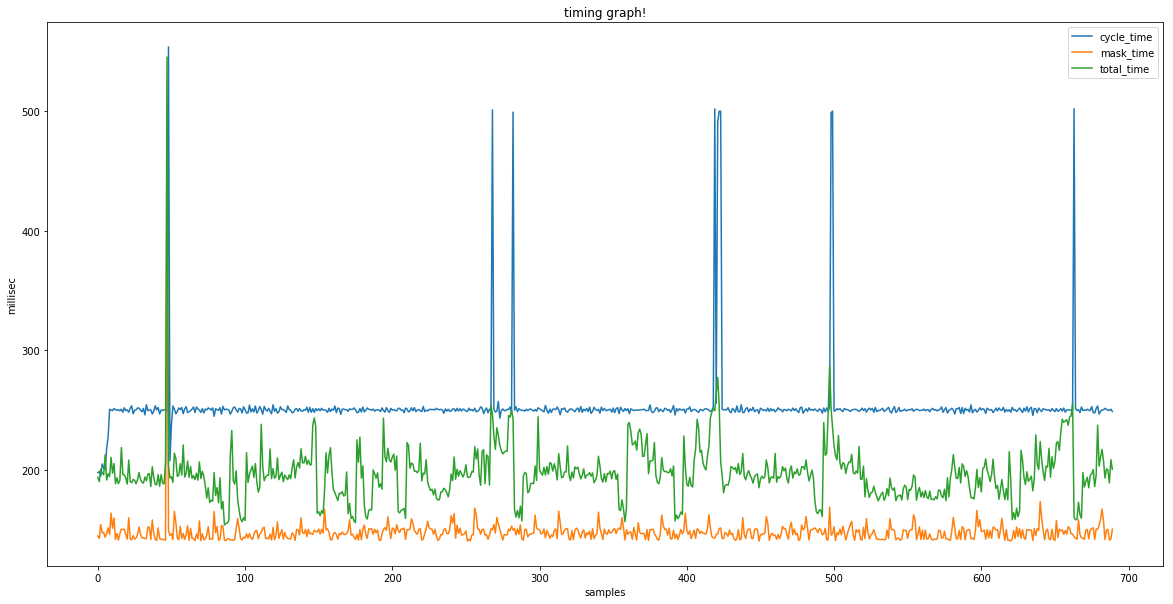

In [31]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20,10))
skip = 10
cycle_time = [0 for _ in range(len(timing.hist)-skip)]
mask_time  = [0 for _ in range(len(timing.hist)-skip)]
total_time = [0 for _ in range(len(timing.hist)-skip)]

for i in range(10, len(timing.hist)):
    cycle_time[i-skip] = timing.hist[i][0]*1000
    mask_time[i-skip] = timing.hist[i][1]*1000
    total_time[i-skip] = timing.hist[i][timing.array_size-1]*1000
    
plt.plot(cycle_time, label = "cycle_time")
plt.plot(mask_time, label = "mask_time")
plt.plot(total_time, label = "total_time")

# naming the x axis
plt.xlabel('samples')
# naming the y axis
plt.ylabel('millisec')
 
# giving a title to my graph
plt.title('timing graph!')
 
plt.legend()

# function to show the plot
plt.show()

The next cell writes the complete stored history to a file, that can be downloaded.

In [ ]:
hist_file = open("history.csv","w")
for i in range(0, len(timing.hist)):
    for j in range(0,timing.array_size):
       hist_file.write(f'{round(timing.hist[i][j]*1000,1)},')
    hist_file.write('\n')
    
hist_file.close()

Execute the next cell to zip up the recorded camera images and masks for download.

In [ ]:
try:
    if os.path.exists("Recording.zip") == True:
        os.remove("Recording.zip")
    !zip -r -q Recording.zip {recording_dir}
except:
    print("Exception at zipping recording") 

print("Done!")

Execute the next cell to zip up the debug output folder for download.

In [ ]:
try:
    if os.path.exists("DebugOut.zip") == True:
        os.remove("DebugOut.zip")
    !zip -r -q DebugOut.zip {DebugOut}
except:
    print("Exception at zipping DebugOut") 
    
print("Done!")

The last cell is only for zipping up the complete notebook folder for download.

In [ ]:
try:
    if os.path.exists("../notebooks.zip") == True:
        os.remove("../notebooks.zip")
    !zip -r -q "../notebooks.zip" "../notebooks"
except:
    print("Exception at zipping DebugOut") 
    
print("Done!")